In [1]:

%matplotlib inline


from dv import AedatFile
import sys, getopt
import pdb
import time
import cv2 as cv
import numpy as np
import pdb
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

"""
    To parse all the events:
        python3 parse_aedat4.py -i filename.raw -n -1
    To parse 23 the events:
        python3 parse_aedat4.py -i filename.raw -n 23
"""


def getInputs(argv):
    inputfile = ""
    outputfile = ""
    try:
        opts, args = getopt.getopt(argv, "i:n:", ["ifile=", "nevents="])
    except getopt.GetoptError:
        print("parse_aedat4.py -i <inputfile> -n <nb_events>")
        sys.exit(2)
    for opt, arg in opts:
        if opt in ("-i", "--ifile"):
            inputfile = arg
        elif opt in ("-n", "--nevents"):
            nb_events = int(arg)
    return inputfile, nb_events


def getNextRow(inputfile):

    with AedatFile(inputfile) as ifile:
        # loop through the "events" stream
        for e in ifile["events"]:
            t = e.timestamp
            x = e.x
            y = e.y
            p = int(e.polarity)
            yield (t, x, y, p)



def undistort(t, x, y):
    
    new_x = x
    new_y = y
    
    return new_x, new_y

def preprocess(m):
    m = np.where(m>0, 255, m)
    m = np.where(m==0, 128, m)
    m = np.where(m<0, 0, m)

    return m


def getColorMap():
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, 256))
    green = np.array([0/256, 255/256, 0/256, 1])
    red = np.array([255/256, 0/256, 0/256, 1])
    black = np.array([0/256, 0/256, 0/256, 1])
    white = np.array([255/256, 255/256, 255/256, 1])
    newcolors[129:256, :] = green  
    newcolors[128, :] = black
    newcolors[0:127, :] = red  
    newcmp = ListedColormap(newcolors)
    
    return newcmp

def print_all(m):
    
    x,y = m.shape
    count_red = 0
    count_green = 0
    count_black = 0
#     print("[\n")
    for i in range(x):
        for j in range (y):
            if m[i,j] == 128:
                count_black += 1
            else:                
#                 print("\t(%d,%d) : %d\n" %(i,j,m[i,j]))
                if m[i,j] < 128:
                    count_red += 1
                if m[i,j] > 128:
                    count_green += 1
#     print("]\n")
    
    print("# red: %d\n" %(count_red))
    print("# green: %d\n" %(count_green))
    print("# black: %d\n" %(count_black))




(640, 480)


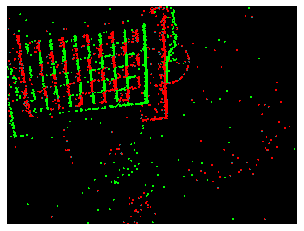

304072
Parser took: 85 seconds.


In [3]:
if __name__ == "__main__":
    
    
    
    
    evcmap = getColorMap()
    
    x_max = 640
    y_max = 480

    screen = np.zeros((x_max, y_max),dtype=int)
    print(screen.shape)

    inputfile = "rec_cam3.aedat4"
    nb_events = -1

    start = time.time()

    line_count = 0
    photo_counter = 0
    change_interval = 1000 # 1ms : 2000Hz  
    for t, x, y, p in getNextRow(inputfile):    
        

        # Extract time offset
        if line_count == 0 :
            first_t = t
            t_next_change = change_interval

        t_relative = t - first_t # first event occurs at t=0

        # Visualize Stuff and Prepare for next frame
        if t_relative > t_next_change:
    
            inactive_pixels = np.sum(screen == 0)
            if inactive_pixels < int(0.99*x_max*y_max):
                screen = preprocess(screen)
#                 plt.figure(figsize=(x_max, y_max))
                plt.imshow(np.transpose(screen), cmap=evcmap)  
                plt.axis('off')
                plt.pause(1)
                print(inactive_pixels)
                photo_counter += 1
                if photo_counter >= 1:
                    break

            # Clear window
            screen = np.zeros((x_max, y_max),dtype=int)
            t_next_change += change_interval
            
        else:
            screen[x,y] = screen[x,y]*0.5 + 2*p-1


        line_count += 1

        # Check if enough events have been parsed
        if (nb_events > 0) and (line_count > nb_events):
            # Stop parsing since nb_events reached
            print(t_relative)
            print(t_next_change)
            break

    stop = time.time()

    elapsed = stop - start
    print("Parser took: " + str(int(elapsed)) + " seconds.")